In [1]:
# Preprocessing: https://github.com/MagedSaeed/farasapy
# Word2vec: https://github.com/bakrianoo/aravec
# TF-IDF, PCA?
# KNN? KMeans?

In [5]:
!unzip Dataset.zip
!pip install torchmetrics

Archive:  Dataset.zip
  inflating: Dataset/dev.csv         
  inflating: Dataset/train.csv       
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing libraries

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchmetrics
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk
from tqdm import tqdm

# Data PreProcessing

In [9]:
train = pd.read_csv('Dataset/train.csv')
text_train, category_train, stance_train = train['text'], train['category'], train['stance']

dev = pd.read_csv('Dataset/dev.csv')
text_dev, category_dev, stance_dev = dev['text'], dev['category'], dev['stance']

In [10]:
train.head(10)

,text,category,stance
0,بيل غيتس يتلقى لقاح #كوفيد19 من غير تصوير الاب...,celebrity,1
1,وزير الصحة لحد اليوم وتحديدا هلأ بمؤتمروا الصح...,info_news,1
2,قولكن رح يكونو اد المسؤولية ب لبنان لما يوصل ...,info_news,1
3,#تركيا.. وزير الصحة فخر الدين قوجة يتلقى أول ج...,celebrity,1
4,وئام وهاب يشتم الدول الخليجية في كل طلة اعلامي...,personal,0
5,"لقاح #كورونا في أميركا.. قلق متزايد من ""التوزي...",info_news,0
6,لبنان اشترى مليونان لقاح امريكي اذا شلنا يلي ع...,info_news,1
7,من عوارض لقاح كورونا<LF>هو تهكير حسابك عتويتر<...,personal,0
8,هناك 1780 مليونيراً في لبنان. ماذا لو فُرضت ال...,unrelated,0
9,دعبول حضرتك منو انت وتطلب من قائد دولة إسلامية...,info_news,1


In [11]:
dev.head(10)

,text,category,stance
0,#مريم_رجوي: <LF>حظر خامنئي المجرم شراء #لقاح_ك...,info_news,1
1,#الصحة:<LF>•تم إعطاء 259.530 جرعة من لقاح #كور...,plan,1
2,#خادم_الحرمين - حفظه الله - يتلقى الجرعة الأول...,celebrity,1
3,#الصحه_العالميه: لقاحات #كورونا آمنة ولا خوف م...,info_news,1
4,"#وزيرة_الصحة ""#هالة_زايد"" تقول إنه يجرى مراجعة...",info_news,1
5,2️⃣ وانتهى الفريق من الدراسات قبل السريرية ونش...,info_news,1
6,عاجل 🔴 <LF>.<LF><LF>.<LF><LF>وزارة الصحة :<LF>...,plan,1
7,#فيديو | السفير الأميركي لدى السعودية بعد تلقي...,info_news,1
8,تصريحات وبس الحكومة مع السيسي علي حسب اللقطة! ...,info_news,0
9,الاتحاد الاوروبي تفاوض لشراء لقاحات الكورونا م...,info_news,1


In [12]:
text_train, category_train, stance_train = np.array(train['text']), np.array(train['category']), np.array(train['stance'])
text_dev, category_dev, stance_dev = np.array(dev['text']), np.array(dev['category']), np.array(dev['stance'])

print(text_train.shape, category_train.shape, stance_train.shape)
print(text_dev.shape, category_dev.shape, stance_dev.shape)

(6988,) (6988,) (6988,)
(1000,) (1000,) (1000,)


In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
def PreProcessing(text):

    # remove links
    text = [re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE) for x in text]
    # text = [re.sub(r'https?:\/\/\S*', '', x, flags=re.MULTILINE) for x in text]

    # remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    text = [emoji_pattern.sub(r'', x) for x in text] # no emoji

    # remove english words
    text = [re.sub(r'\s*[A-Za-z]+\b', '' , x) for x in text]

    # tokenize
    text = [nltk.tokenize.word_tokenize(x) for x in text]

    # # remove stop-words
    # stopwords = set(nltk.corpus.stopwords.words("arabic"))

    # for i in range(len(text)):
    #     text[i] = [word for word in text[i] if word not in stopwords]


    for i in range(len(text)):
        text[i] = [word for word in text[i] if len(word)>2]

    # but anything in empty strings
    for i in range(len(text)):
        if(len(text[i])==0):
            text[i]='<unk>'
    
    return text

In [15]:
print(max(text_train, key=len))
text_train = PreProcessing(text_train)
text_dev = PreProcessing(text_dev)

الامريكيين متهمون بصنع ونشر فيروس كورونا ولذلك لا يمكن الوثوق بهم”<LF>الإمام الخامنئي<LF><LF>#لقاح_آمن	info_news	0
train	حبيبنا وقرة أعيننا سيدي #خادم_الحرمين_الشريفين الملك سلمان حفظه الله يتلقى الجرعة الأولى من لقاح كورنا … نفعه الله به ومتعه بالصحة والعافيه. https://t.co/AJRzC7dCWe	celebrity	1
train	رغم تلقيه جرعتين من لقاح #فايزر.. إصابة كبير حاخامات #تل_أبيب، يسرائيل لاو،  83 عاما، بفيروس #كورونا، حيث انتقلت له العدوى من زوجته بعد مخالطتها مصابا آخر https://t.co/RGI6WTgrxf	celebrity	0
train	تلقيت قبل قليل الجرعة الثانية من لقاح كورونا، وكلي فخر بجهود وطننا الغالي وتوجيهات قيادتنا الرشيدة التي تؤكد أن صحة الإنسان أولاً.  🇸🇦🇸🇦🇸🇦🇸🇦 https://t.co/XGstr9Zvzf	info_news	1
train	شركة صحة": جزيل الشكر للمواطنة ملهية شويرب سعيد العامري، التي تبلغ ١٠٢ عاماً<LF>لكونها قدوة لجميع أفراد المجتمع من خلال <LF> تلقيها أول جرعة من لقاح كوفيد-19 في مركز القوع الصحي #الإمارات_اليوم https://t.co/uBSCd0JZ4Y


In [16]:
with open('processed_train.txt','w', encoding='utf8') as f:
	for i in text_train:
		f.write('%s\n'%i)
print(text_train[0])

['بيل', 'غيتس', 'يتلقى', 'لقاح', 'كوفيد19', 'غير', 'تصوير', 'الابرة', 'السيرنجة', 'الدواء', 'لابس', 'بولو', 'صيفي', 'الشتاء', 'يقول', 'إحدى', 'مزايا', 'عمر', 'عامًا', 'انه', 'مؤهل', 'للحصول', 'على', 'اللقاح', '...', 'يعنى', 'كان', 'يحتاج', 'اللقاح', 'كان', 'عمره', 'اصغر']


# TFIDF

In [17]:
def get_TFIDF(in_corpus): # list of list of str
  corpus = [' '.join(l) for l in in_corpus]
  print('corpus size: ', len(corpus))
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(corpus)
  return X.getH().toarray(), X.toarray(), vectorizer.get_feature_names_out() # list of words, vocab

In [18]:
def cosine_similarity(word1, word2, vocab):
  # vocab = vectorizer_TF_IDF.get_feature_names_out()
  ind1 = np.where(vocab==word1)[0].item()
  ind2 = np.where(vocab==word2)[0].item()
  return np.dot(temp_TF_IDF[ind1], temp_TF_IDF[ind2])/(np.sqrt(np.sum(temp_TF_IDF[ind1]**2))*np.sqrt(np.sum(temp_TF_IDF[ind2]**2)))

In [19]:
from sklearn.decomposition import PCA
def apply_PCA(list_of_features, n_components): # take best n_components features for all samples
  pca = PCA(n_components=n_components)
  return pca.fit_transform(list_of_features)

In [20]:
import matplotlib.pyplot as plt
def plot_annotated(points, labels=[]):
  """
  [[0 1]
  [2 3]]
  -> (0,1), (2, 3)
  """
  plt.scatter(points[:,0], points[:,1])
  for i, txt in enumerate(labels):
    plt.annotate(txt, (points[i,0], points[i,1]))
  plt.show()

corpus size:  4
9 9


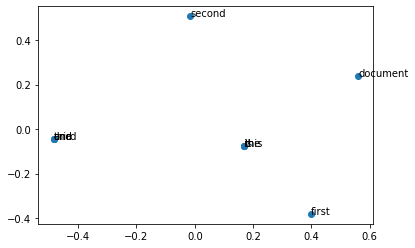

0.813894995377407
1.0
1.0


In [21]:
corpus_TF_IDF = [
    ['This','is', 'the', 'first', 'document.'],
    ['This', 'document', 'is', 'the', 'second', 'document.'],
    ['And', 'this', 'is', 'the', 'third', 'one.'],
    ['Is', 'this', 'the', 'first', 'document?'],
]
temp_TF_IDF, temp2_TF_IDF, vocab_tf_idf = get_TFIDF(corpus_TF_IDF)
after_pca = apply_PCA(temp_TF_IDF, 2)
print(len(temp_TF_IDF), len(after_pca))
plot_annotated(after_pca, vocab_tf_idf)
print(cosine_similarity('this', 'first', vocab_tf_idf))
print(cosine_similarity('this', 'is', vocab_tf_idf))
print(cosine_similarity('one', 'third', vocab_tf_idf))

In [115]:
word_dim = 100

In [116]:


reduced_tfidf_train = apply_PCA(get_TFIDF(text_train)[1], word_dim)
reduced_tfidf_dev = apply_PCA(get_TFIDF(text_dev)[1], word_dim)



corpus size:  6988
corpus size:  1000


In [117]:
print(len(reduced_tfidf_train))
print(len(text_train))

6988
6988


In [118]:
print(len(reduced_tfidf_train[0]))
print(reduced_tfidf_train.size)

100
698800


In [119]:
print(stance_dev.shape)

(1000,)


In [120]:
def NB_TFIDF_stance():
  from sklearn.naive_bayes import GaussianNB
  from sklearn.metrics import f1_score
  gnb = GaussianNB()
  y_pred_tfidf = gnb.fit(reduced_tfidf_train, stance_train).predict(reduced_tfidf_dev)
  print("tfidf NB stance accuracy = ", np.sum(y_pred_tfidf==stance_dev)/stance_dev.size)
  f1Score_tfidf = f1_score(y_pred_tfidf, stance_dev, average='macro')
  print("tfidf NB stance f1 score = ", f1Score_tfidf)

NB_TFIDF_stance()

tfidf NB stance accuracy =  0.716
tfidf NB stance f1 score =  0.42111751821081295


In [121]:
def NB_TFIDF_category():
  from sklearn.naive_bayes import GaussianNB
  from sklearn.metrics import f1_score
  gnb = GaussianNB()
  y_pred_tfidf = gnb.fit(reduced_tfidf_train, category_train).predict(reduced_tfidf_dev)
  print("tfidf NB categories accuracy = ", np.sum(y_pred_tfidf==category_dev)/category_dev.size)
  f1Score_tfidf = f1_score(y_pred_tfidf, category_dev, average='macro')
  print("tfidf NB categories f1 score = ", f1Score_tfidf)

NB_TFIDF_category()

tfidf NB categories accuracy =  0.392
tfidf NB categories f1 score =  0.1679505170536444


In [122]:
def SVM_TFIDF_stance():
  from sklearn import svm
  from sklearn.metrics import f1_score
  clf = svm.SVC()
  clf.fit(reduced_tfidf_train, stance_train)
  y_pred_tfidf = clf.predict(reduced_tfidf_dev)
  print("tfidf SVM stance accuracy = ", np.sum(y_pred_tfidf==stance_dev)/stance_dev.size)
  f1Score_tfidf = f1_score(y_pred_tfidf, stance_dev, average='macro')
  print("tfidf SVM stance f1 score = ", f1Score_tfidf)

SVM_TFIDF_stance()

tfidf SVM stance accuracy =  0.804
tfidf SVM stance f1 score =  0.29711751662971175


In [123]:
def SVM_TFIDF_category():
  from sklearn import svm
  from sklearn.metrics import f1_score
  clf = svm.SVC()
  clf.fit(reduced_tfidf_train, category_train)
  y_pred_tfidf = clf.predict(reduced_tfidf_dev)
  print("tfidf SVM categories accuracy = ", np.sum(y_pred_tfidf==category_dev)/category_dev.size)
  f1Score_tfidf = f1_score(y_pred_tfidf, category_dev, average='macro')
  print("tfidf SVM categories f1 score = ", f1Score_tfidf)

SVM_TFIDF_category()

tfidf SVM categories accuracy =  0.586
tfidf SVM categories f1 score =  0.12828328128091956


# LSTM

In [104]:
def BuildVocab(text, pad='<pad>', unk='<unk>'):

    vocab = set()    
    for x in text:
        vocab |= set(x)

    vocab = [pad, unk] + list(vocab)

    id2word = {i: word for i, word in enumerate(vocab)}
    word2id = {word: i for i, word in id2word.items()}
    vocab_size = len(vocab)

    return vocab_size, vocab, id2word, word2id    

In [31]:
vocab_size, vocab, id2word, word2id = BuildVocab(text_train)
print(vocab_size)

32058


In [32]:
categories = set(category_train)
print(categories)
category2id = {word:i for i, word in enumerate(list(categories))}
print(category2id['celebrity'])

{'plan', 'restrictions', 'unrelated', 'info_news', 'others', 'personal', 'rumors', 'advice', 'requests', 'celebrity'}
9


# Model Building

## LSTM

### Ideas to try
1) bi-directional
2) pre-training
3) multi-layers
4) BERT
5) transformers notebook
6) packed_padded_sequences
7) pre-trained embedding

### Building Model

In [33]:
class Dataset(torch.utils.data.Dataset):

  def __init__(self, x, y, pad='<pad>', unk='<unk>', word2id=word2id):

    x = x.copy()

    # src lengths to be used in pack padded
    self.seq_lengths = torch.LongTensor(list(map(len, x)))

    print(x[0], self.seq_lengths[0])

    for i in range(len(x)):
      x[i] = [word2id[word] if word in word2id else word2id[unk] for word in x[i]]
    
    print(x[0])

    self.X = torch.nn.utils.rnn.pad_sequence([torch.tensor(sentence) for sentence in x], batch_first=True, padding_value=word2id[pad])

    # sort sequeces decreasing in size
    self.seq_lengths, perm_idx = self.seq_lengths.sort(0, descending=True)
    self.X = self.X[perm_idx]

    print(self.X[0])

    print(self.X.shape)

    print(min(self.seq_lengths))
    
    self.Y = torch.tensor(y)
    self.len = len(x)
    self.pad = pad

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx], self.seq_lengths[idx]

In [34]:
stance_train_dataset = Dataset(text_train, stance_train + 1)
category_train_dataset = Dataset(text_train, [category2id[category] for category in category_train])

stance_dev_dataset = Dataset(text_dev, stance_dev + 1)
category_dev_dataset = Dataset(text_dev, [category2id[category] for category in category_dev])

['بيل', 'غيتس', 'يتلقى', 'لقاح', 'كوفيد19', 'غير', 'تصوير', 'الابرة', 'السيرنجة', 'الدواء', 'لابس', 'بولو', 'صيفي', 'الشتاء', 'يقول', 'إحدى', 'مزايا', 'عمر', 'عامًا', 'انه', 'مؤهل', 'للحصول', 'على', 'اللقاح', '...', 'يعنى', 'كان', 'يحتاج', 'اللقاح', 'كان', 'عمره', 'اصغر'] tensor(32)
[8, 19696, 7505, 6768, 26894, 15372, 10657, 12699, 18035, 11124, 31879, 21228, 24528, 27004, 5517, 25780, 19912, 6904, 18880, 27368, 26892, 16581, 18459, 5269, 21805, 19643, 12605, 17578, 5269, 12605, 3001, 3829]
tensor([13360, 23736,  2452, 16041,  1731,  3149,  7740,  6573, 25038, 10802,
        10549, 13839, 10339, 12268, 10742, 19217, 18778, 18598, 27933, 10320,
        21477, 21467, 22111,  7505, 16068, 30955,  6768, 18079, 27205, 22111,
        12894,  2717, 16242,  2124,  8301, 12000,  6768,  4332, 31647, 31874,
        23156, 32041,  3675,  7362, 19248, 25325, 17472,    81,  9900, 29497,
        18001, 19120, 29957, 31385, 12620, 23031, 20704, 21376, 16068, 16737,
         6768, 17472, 31209, 20908,

In [35]:
class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, dropout=dropout)

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        #src = [src len, batch size]
        
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        #embedded = [src len, batch size, emb dim]

        packed_embedded =  torch.nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu().numpy(), batch_first=False)

        outputs, (hidden, cell) = self.lstm(packed_embedded)
        #outputs = [src len, batch size, hid dim]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        #outputs are always from the top hidden layer

        prediction = self.fc_out(hidden)
        #prediction = [1, batch size, output dim]

        prediction = prediction.squeeze(0)
        #prediction = [batch size, output dim]

        return prediction        

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Training

In [37]:

def train(model, train_dataset, batch_size=512, epochs=10, learning_rate=0.01):
  
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

  # criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  
  model = model.to(device)
  criterion = criterion.to(device)

  for epoch_num in range(epochs):
    total_acc_train = 0.0
    total_loss_train = 0.0
    all_output_labels = None
    all_desired_labels = None
    for train_input, train_label, src_len in tqdm(train_dataloader):

      train_input = train_input.to(device).permute(1, 0)
      # print(train_input.shape)
      train_label = train_label.to(device)

      output = model(train_input, src_len)

      # print(output.shape, train_label.shape)
      
      batch_loss = criterion(output.view(-1, model.output_dim), train_label.view(-1))

      total_loss_train += batch_loss
      
      predicted_labels = torch.argmax(output, -1)
      acc = torch.sum(predicted_labels == train_label) 
      total_acc_train += acc


      all_output_labels = torch.cat((all_output_labels, predicted_labels)) if all_output_labels is not None else predicted_labels
      all_desired_labels = torch.cat((all_desired_labels, train_label)) if all_desired_labels is not None else train_label
      

      optimizer.zero_grad()

      batch_loss.backward()

      optimizer.step()
      
    epoch_loss = total_loss_train / len(train_dataset)

    epoch_acc = total_acc_train / len(train_dataset)

    f1Score_fun = torchmetrics.F1Score(task="multiclass", num_classes=model.output_dim, average='macro')

    print(all_output_labels)
    print(all_desired_labels)
    f1Score = f1Score_fun(all_output_labels, all_desired_labels)

    print(
        f'Epochs: {epoch_num + 1} | Train Loss: {epoch_loss} \
        | Train Accuracy: {epoch_acc} | F1 Score: {f1Score}\n')


In [38]:
INPUT_DIM = vocab_size
OUTPUT_DIM = 3
EMB_DIM = 50 #256
HID_DIM = 50 #512
DROPOUT = 0.0

stance_model = LSTM(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT).to(device)

In [39]:
print(stance_model.embedding.float())

Embedding(32058, 50)


In [83]:
# comparison_list = []
# l1 = stance_model.embedding(stance_train_dataset.X).detach().numpy()
# print(len(l1))
# print(len(reduced_tfidf_embeddings))
# for i in range(len(reduced_tfidf_embeddings)):
#   temp = np.dot(l1[i], reduced_tfidf_embeddings[i]) / (np.sqrt(np.sum(reduced_tfidf_embeddings[i]**2))*np.sqrt(np.sum(l1[i]**2)))
#   comparison_list.append(temp)

In [84]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
stance_model.apply(init_weights)

LSTM(
  (embedding): Embedding(32058, 50)
  (lstm): LSTM(50, 50)
  (fc_out): Linear(in_features=50, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [85]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(stance_model):,} trainable parameters')

The model has 1,623,453 trainable parameters


In [86]:
train(stance_model, stance_train_dataset, epochs=20)

100%|██████████| 14/14 [00:04<00:00,  3.28it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 1 | Train Loss: 0.0015010422794148326         | Train Accuracy: 0.7925014495849609 | F1 Score: 0.29474693536758423



100%|██████████| 14/14 [00:03<00:00,  3.60it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 2 | Train Loss: 0.0012273920001462102         | Train Accuracy: 0.7925014495849609 | F1 Score: 0.29474693536758423



100%|██████████| 14/14 [00:04<00:00,  3.42it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 3 | Train Loss: 0.0009096839930862188         | Train Accuracy: 0.8106754422187805 | F1 Score: 0.42098042368888855



100%|██████████| 14/14 [00:04<00:00,  3.48it/s]


tensor([2, 1, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 4 | Train Loss: 0.0006230577710084617         | Train Accuracy: 0.883085310459137 | F1 Score: 0.5466014742851257



100%|██████████| 14/14 [00:03<00:00,  3.58it/s]


tensor([2, 1, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 5 | Train Loss: 0.0005562735605053604         | Train Accuracy: 0.8938179612159729 | F1 Score: 0.56060791015625



100%|██████████| 14/14 [00:04<00:00,  3.37it/s]


tensor([2, 1, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 6 | Train Loss: 0.0005049277096986771         | Train Accuracy: 0.9068403244018555 | F1 Score: 0.6822534203529358



100%|██████████| 14/14 [00:03<00:00,  3.59it/s]


tensor([2, 1, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 7 | Train Loss: 0.00037350456113927066         | Train Accuracy: 0.9368917942047119 | F1 Score: 0.8410977125167847



100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 8 | Train Loss: 0.0004146290011703968         | Train Accuracy: 0.9274470806121826 | F1 Score: 0.8426430225372314



100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 9 | Train Loss: 0.00041122001130133867         | Train Accuracy: 0.9367486834526062 | F1 Score: 0.8625155687332153



100%|██████████| 14/14 [00:04<00:00,  3.47it/s]


tensor([2, 1, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 10 | Train Loss: 0.0004034863377455622         | Train Accuracy: 0.9301660060882568 | F1 Score: 0.8457803130149841



100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 11 | Train Loss: 0.0002502267016097903         | Train Accuracy: 0.9583571553230286 | F1 Score: 0.9060056209564209



100%|██████████| 14/14 [00:03<00:00,  3.56it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 12 | Train Loss: 0.000201490824110806         | Train Accuracy: 0.9642243981361389 | F1 Score: 0.9217232465744019



100%|██████████| 14/14 [00:03<00:00,  3.56it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 13 | Train Loss: 0.00018927959899883717         | Train Accuracy: 0.9670864343643188 | F1 Score: 0.9302529096603394



100%|██████████| 14/14 [00:03<00:00,  3.57it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 14 | Train Loss: 0.00016893511929083616         | Train Accuracy: 0.9690898656845093 | F1 Score: 0.9347975254058838



100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 15 | Train Loss: 0.00014989846386015415         | Train Accuracy: 0.9725243449211121 | F1 Score: 0.9428045153617859



100%|██████████| 14/14 [00:03<00:00,  3.57it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 16 | Train Loss: 0.0001368038065265864         | Train Accuracy: 0.9735260605812073 | F1 Score: 0.9437968730926514



100%|██████████| 14/14 [00:03<00:00,  3.56it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 17 | Train Loss: 0.00012787191371899098         | Train Accuracy: 0.9743846654891968 | F1 Score: 0.9467681646347046



100%|██████████| 14/14 [00:03<00:00,  3.59it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 18 | Train Loss: 0.00012020522990496829         | Train Accuracy: 0.9752432703971863 | F1 Score: 0.9481027126312256



100%|██████████| 14/14 [00:03<00:00,  3.54it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 19 | Train Loss: 0.00011339654884068295         | Train Accuracy: 0.9769604802131653 | F1 Score: 0.9521799087524414



100%|██████████| 14/14 [00:03<00:00,  3.58it/s]


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 2,  ..., 2, 2, 2])
Epochs: 20 | Train Loss: 0.0001131380267906934         | Train Accuracy: 0.9758157134056091 | F1 Score: 0.9508205652236938



In [87]:
INPUT_DIM = vocab_size
OUTPUT_DIM = 10
EMB_DIM = 50 #256
HID_DIM = 50 #512
DROPOUT = 0.0

category_model = LSTM(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT).to(device)

In [88]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
category_model.apply(init_weights)

LSTM(
  (embedding): Embedding(32058, 50)
  (lstm): LSTM(50, 50)
  (fc_out): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [89]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(category_model):,} trainable parameters')

The model has 1,623,810 trainable parameters


In [90]:
train(category_model, category_train_dataset, epochs=20)

100%|██████████| 14/14 [00:04<00:00,  3.20it/s]


tensor([5, 5, 5,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 1 | Train Loss: 0.003550139255821705         | Train Accuracy: 0.43889525532722473 | F1 Score: 0.08081360161304474



100%|██████████| 14/14 [00:03<00:00,  3.70it/s]


tensor([3, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 2 | Train Loss: 0.0030367986764758825         | Train Accuracy: 0.5174584984779358 | F1 Score: 0.06820067763328552



100%|██████████| 14/14 [00:04<00:00,  3.36it/s]


tensor([3, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 3 | Train Loss: 0.0028640441596508026         | Train Accuracy: 0.5186033248901367 | F1 Score: 0.07057829946279526



100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


tensor([3, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 4 | Train Loss: 0.0024570282548666         | Train Accuracy: 0.596737265586853 | F1 Score: 0.1544865518808365



100%|██████████| 14/14 [00:03<00:00,  3.72it/s]


tensor([3, 5, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 5 | Train Loss: 0.001949188532307744         | Train Accuracy: 0.6924728155136108 | F1 Score: 0.253777414560318



100%|██████████| 14/14 [00:03<00:00,  3.89it/s]


tensor([9, 9, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 6 | Train Loss: 0.0016158450162038207         | Train Accuracy: 0.7442759275436401 | F1 Score: 0.308613121509552



100%|██████████| 14/14 [00:03<00:00,  3.91it/s]


tensor([5, 5, 3,  ..., 3, 3, 9])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 7 | Train Loss: 0.0013089862186461687         | Train Accuracy: 0.7997996807098389 | F1 Score: 0.3876025676727295



100%|██████████| 14/14 [00:03<00:00,  3.89it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 8 | Train Loss: 0.0012716333149001002         | Train Accuracy: 0.8043789267539978 | F1 Score: 0.4051602780818939



100%|██████████| 14/14 [00:03<00:00,  3.82it/s]


tensor([9, 0, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 9 | Train Loss: 0.001260849996469915         | Train Accuracy: 0.8008013963699341 | F1 Score: 0.39060020446777344



100%|██████████| 14/14 [00:03<00:00,  3.82it/s]


tensor([5, 5, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 10 | Train Loss: 0.0011377468472346663         | Train Accuracy: 0.829994261264801 | F1 Score: 0.43045973777770996



100%|██████████| 14/14 [00:03<00:00,  3.80it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 11 | Train Loss: 0.0010965637629851699         | Train Accuracy: 0.839009702205658 | F1 Score: 0.466233491897583



100%|██████████| 14/14 [00:03<00:00,  3.81it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 12 | Train Loss: 0.0009533627890050411         | Train Accuracy: 0.8501717448234558 | F1 Score: 0.4842141270637512



100%|██████████| 14/14 [00:03<00:00,  3.79it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 13 | Train Loss: 0.0008326356182806194         | Train Accuracy: 0.8709215521812439 | F1 Score: 0.5190879106521606



100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 14 | Train Loss: 0.0007231909548863769         | Train Accuracy: 0.8936748504638672 | F1 Score: 0.6291194558143616



100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 15 | Train Loss: 0.0005737235187552869         | Train Accuracy: 0.9114195704460144 | F1 Score: 0.7016768455505371



100%|██████████| 14/14 [00:03<00:00,  3.78it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 16 | Train Loss: 0.0005066758021712303         | Train Accuracy: 0.9221522808074951 | F1 Score: 0.7478197813034058



100%|██████████| 14/14 [00:03<00:00,  3.78it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 17 | Train Loss: 0.00045681154006160796         | Train Accuracy: 0.929593563079834 | F1 Score: 0.7924187183380127



100%|██████████| 14/14 [00:03<00:00,  3.85it/s]


tensor([9, 2, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 18 | Train Loss: 0.0004134778573643416         | Train Accuracy: 0.9367486834526062 | F1 Score: 0.8495901226997375



100%|██████████| 14/14 [00:03<00:00,  3.86it/s]


tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 19 | Train Loss: 0.00039205237408168614         | Train Accuracy: 0.9361763000488281 | F1 Score: 0.8577417135238647



100%|██████████| 14/14 [00:03<00:00,  3.83it/s]

tensor([9, 3, 3,  ..., 3, 3, 3])
tensor([9, 3, 3,  ..., 3, 3, 3])
Epochs: 20 | Train Loss: 0.00042489016777835786         | Train Accuracy: 0.9337435364723206 | F1 Score: 0.8714468479156494



## Evaluation

In [91]:
def evaluate(model, test_dataset, batch_size=512):

  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model = model.to(device)

  total_acc_test = 0.0
  
  with torch.no_grad():
    all_output_labels = None
    all_desired_labels = None
    for test_input, test_label, src_len in tqdm(test_dataloader):

      test_input = test_input.to(device).permute(1, 0)
      test_label = test_label.to(device)


      output = model(test_input, src_len)

      acc = torch.sum(torch.argmax(output, -1)==test_label)
      total_acc_test += acc
      
      all_output_labels = torch.cat((all_output_labels, torch.argmax(output, -1))) if all_output_labels is not None else torch.argmax(output, -1)
      all_desired_labels = torch.cat((all_desired_labels, test_label)) if all_desired_labels is not None else test_label


    total_acc_test /= len(test_dataset)
    f1Score = torchmetrics.F1Score(task="multiclass", num_classes=model.output_dim, average='macro')
      
    f1Score = f1Score(all_output_labels, all_desired_labels)  
  print(f'\nDev Accuracy: {total_acc_test} | f1Score: {f1Score}')

In [92]:
evaluate(stance_model, stance_dev_dataset)

100%|██████████| 2/2 [00:00<00:00, 30.44it/s]


Dev Accuracy: 0.7269999980926514 | f1Score: 0.3150275945663452


In [93]:
evaluate(category_model, category_dev_dataset)

100%|██████████| 2/2 [00:00<00:00, 27.50it/s]


Dev Accuracy: 0.2930000126361847 | f1Score: 0.0964256003499031
